In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import keras
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import gc

In [2]:
train_dir = "../input/dermnet-images-final/dermnet images"

In [3]:
labels_dict = {
    'Acne-and-Rosacea-Photos' : 0,
    'Eczema-and-Atopic-Dermatitis-Photos' : 1,
    'Seborrheic-Keratoses-and-other-Benign-Tumors' : 2,
    'Urticaria-Hives' : 3
}
def data_loader():
    #imgs = np.empty(shape=[0, 256, 256, 3])
    images = []
    labels = []
    size = 256,256
    print("Loading...")
    for folder in sorted(os.listdir(train_dir)):
        print(folder)
        for image in os.listdir(train_dir + "/" + folder):
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            #temp_img = [temp_img]
            images.append(temp_img)
            if folder == 'Acne-and-Rosacea-Photos':
                labels.append(labels_dict['Acne-and-Rosacea-Photos'])
            elif folder == 'Eczema-and-Atopic-Dermatitis-Photos':
                labels.append(labels_dict['Eczema-and-Atopic-Dermatitis-Photos'])
            elif folder == 'Seborrheic-Keratoses-and-other-Benign-Tumors':
                labels.append(labels_dict['Seborrheic-Keratoses-and-other-Benign-Tumors'])
            elif folder == 'Urticaria-Hives':
                labels.append(labels_dict['Urticaria-Hives'])
            #del temp_img, image
            #gc.collect()
    images = np.array(images)
    #imgs = np.append(imgs, images, axis=0)
    #del images
    #gc.collect()
    #imgs = np.array(images)
    #print(narr.shape)
    #imgs = np.append(imgs, narr, axis=0)
    print('Total images : ',images.shape[0])
    #del images,narrr 
    #gc.collect()

    #images = images.astype('float32')/255.0
    
    templabels = labels
    
    labels = to_categorical(labels)
        
    X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.95, random_state=42)
    #X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.85, random_state=42)
    
    del images, labels
    gc.collect()
    
    #return X_train, y_train, X_test, y_test, X_val, y_val, templabels
    return X_train, y_train, X_test, y_test, templabels

In [4]:
X_train, y_train, X_test, y_test, labels = data_loader()

Loading...
Acne-and-Rosacea-Photos
Eczema-and-Atopic-Dermatitis-Photos
Seborrheic-Keratoses-and-other-Benign-Tumors
Urticaria-Hives
Total images :  5017


In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.optimizers import SGD
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import math
from math import *
from keras import backend

class CosineAnnealingLearningRateSchedule(Callback):
    from keras import backend

    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lrates = list()
 
    # calculate learning rate for an epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = floor(n_epochs/n_cycles)
        cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_max/2 * (cos(cos_inner) + 1)
 
    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs=None):
        # calculate learning rate
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
        # set learning rate
        backend.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrates.append(lr)

In [7]:
#!pip install git+https://github.com/qubvel/efficientnet

In [8]:
!/opt/conda/bin/python3.7 -m pip install --upgrade pip

     |████████████████████████████████| 1.5 MB 549 kB/s 
  Attempting uninstall: pip
    Found existing installation: pip 20.2.2
    Uninstalling pip-20.2.2:
      Successfully uninstalled pip-20.2.2


In [9]:
!pip install -q tensorflow-model-optimization 

In [10]:
from keras.optimizers import Adam, Adadelta
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, SpatialDropout2D, BatchNormalization, LeakyReLU, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.applications.vgg16 import VGG16
#from efficientnet.keras import EfficientNetB3
from keras.models import Model
import tensorflow as tf
import tensorflow_model_optimization as tfmot
#%load_ext tensorboard

def create_model():
    input_shape = (256, 256, 3)
    num_classes = 4

    model = VGG16(weights = 'imagenet', include_top=False, input_shape=input_shape)
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat = Flatten()(model.layers[-1].output)
    class1 = Dense(128)(flat)
    drop1 = Dropout(0.2)(class1)
    act1 = LeakyReLU(alpha=0.1)(drop1)
    class2 = Dense(128)(act1)
    drop2 = Dropout(0.2)(class2)
    act2 = LeakyReLU(alpha=0.1)(drop2)
    output = Dense(num_classes, activation='softmax')(act2)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    
    sgd = SGD(momentum = 0.9)
    #, decay = 1e-6, nesterov = True)
    adam = Adam()
    
    model.compile(loss='categorical_crossentropy',
            optimizer=adam,
            metrics=['accuracy'])

    print("MODEL CREATED")
    model.summary()
    return model

In [11]:
cfg = dict(
           batch_size=32,    
           lr_start=0.00005,
           lr_max=0.0000125,
           lr_min=0.00001,
           lr_rampup=5,
           lr_sustain=0,
           lr_decay=0.8
        )

In [12]:
from keras.callbacks import LearningRateScheduler

def getLearnRateCallback(cfg):
    
    ''' Using callbacks for learning rate adjustments. '''
    
    lr_start = cfg['lr_start']
    lr_max = cfg['lr_max'] * cfg['batch_size']
    lr_min = cfg['lr_min']
    lr_rampup = cfg['lr_rampup']
    lr_sustain = cfg['lr_sustain']
    lr_decay = cfg['lr_decay']

    def lrfn(epoch):
        if epoch < lr_rampup:
            lr = (lr_max - lr_start) / lr_rampup * epoch + lr_start
        elif epoch < lr_rampup + lr_sustain:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_rampup -
                                                lr_sustain) + lr_min
        return lr

    lr_callback = LearningRateScheduler(lrfn, verbose=True)
    return lr_callback

In [13]:
datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=True,
        samplewise_center=False,
        featurewise_std_normalization=True,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        shear_range = 0.2,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        validation_split=0.15)

datagen.fit(X_train)

In [14]:
train_iterator = datagen.flow(X_train, y_train, subset='training', batch_size=cfg['batch_size'])
val_iterator = datagen.flow(X_train, y_train, subset='validation', batch_size=cfg['batch_size'])

In [15]:
from keras.callbacks import EarlyStopping
import datetime
def fit_model():
    checkpoint = ModelCheckpoint(
        'weights-{epoch:02d}-{loss:.4f}.hdf5',
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min',
        save_freq = 4445
  )
    n_epochs = 200
    n_cycles = n_epochs/20
    #ca = CosineAnnealingLearningRateSchedule(n_epochs, n_cycles, 0.001, verbose=1), getLearnRateCallback(cfg)
    #logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    callbacks = [tfmot.sparsity.keras.UpdatePruningStep(),
                 #tfmot.sparsity.keras.PruningSummaries(log_dir=logdir, profile_batch=0),
                 EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='max'),
                 checkpoint]
    #model_hist = model.fit(train_iterator, epochs = n_epochs, callbacks = callbacks,  validation_data = val_iterator, verbose=1)
    
    pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0, final_sparsity=0.5,
        begin_step=2000, end_step=4000)

    model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(
        model, pruning_schedule=pruning_schedule)
    
    model_for_pruning.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model_hist = model_for_pruning.fit(train_iterator, epochs = n_epochs, callbacks = callbacks,  validation_data = val_iterator, verbose=1)
    return model_hist

In [16]:
model = create_model()
curr_model_hist = fit_model()

58892288/58889256 [==============================] - 0s 0us/step
MODEL CREATED
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________

In [17]:
model.save('model')

In [18]:
#from tensorboard import notebook
#notebook.list()

In [19]:
#notebook.display(port=6006, height=1000) 

In [20]:
evaluate_metrics = model.evaluate(X_test, y_test)
print("\nTest Accuracy = ", "{:.2f}%".format(evaluate_metrics[1]*100),"\nTest loss = " ,"{:.6f}".format(evaluate_metrics[0]))

8/8 [==============================] - 1s 146ms/step - loss: 47.4120 - accuracy: 0.7092

Test Accuracy =  70.92% 
Test loss =  47.411987


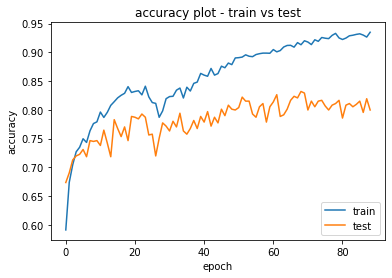

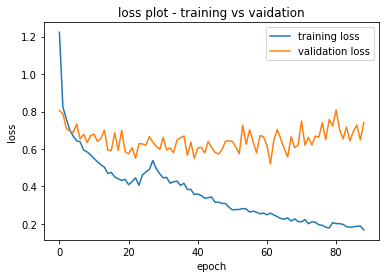

In [21]:
def plot_accuracy(y):
    if(y == True):
        plt.plot(curr_model_hist.history['accuracy'])
        plt.plot(curr_model_hist.history['val_accuracy'])
        plt.legend(['train', 'test'], loc='lower right')
        plt.title('accuracy plot - train vs test')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.show()
    else:
        pass
    return

def plot_loss(y):
    if(y == True):
        plt.plot(curr_model_hist.history['loss'])
        plt.plot(curr_model_hist.history['val_loss'])
        plt.legend(['training loss', 'validation loss'], loc = 'upper right')
        plt.title('loss plot - training vs vaidation')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
    else:
        pass
    return


plot_accuracy(True)
plot_loss(True)

In [22]:
y_pred = np.round(model.predict(X_test), 0)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
y_pred1 = y_pred.reshape(len(y_pred), 1)
onehot_encoded = onehot_encoder.fit_transform(y_pred1)

In [23]:
from sklearn.metrics import roc_auc_score

print("ROC AUC Score: ",roc_auc_score(y_test, onehot_encoded))

ROC AUC Score:  0.7371239973734734


In [24]:
from sklearn.metrics import f1_score
from sklearn import metrics
from numpy import argmax

print(metrics.classification_report(y_test.argmax(axis = 1), y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.551     0.731     0.628        52
           1      0.842     0.721     0.777       111
           2      0.702     0.776     0.737        76
           3      0.333     0.083     0.133        12

    accuracy                          0.709       251
   macro avg      0.607     0.578     0.569       251
weighted avg      0.715     0.709     0.703       251



In [25]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test.argmax(axis=1), y_pred)
matrix

array([[38,  8,  6,  0],
       [12, 80, 18,  1],
       [11,  5, 59,  1],
       [ 8,  2,  1,  1]])

In [26]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model)

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_model = converter.convert()

converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_pruned_model = converter.convert()

open("quantized_pruned_model_tflite.tflite", "wb").write(quantized_pruned_model)
open("pruned_model_tflite.tflite", "wb").write(pruned_model)

print("TFlite file generated")

TFlite file generated


In [27]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(X_test):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)
  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  prediction_digits = to_categorical(prediction_digits)
  accuracy = (prediction_digits == y_test).mean()
  return accuracy



interpreter = tf.lite.Interpreter(model_content=pruned_model)
interpreter.allocate_tensors()
test_accuracy = evaluate_model(interpreter)

print('Pruned TFLite test accuracy:', test_accuracy)

interpreter = tf.lite.Interpreter(model_content=quantized_pruned_model)
interpreter.allocate_tensors()
test_accuracy_quantized = evaluate_model(interpreter)

print('Pruned and Quantized TFLite test accuracy:', test_accuracy_quantized)

Evaluated on 0 results so far.


Pruned TFLite test accuracy: 0.8545816733067729
Evaluated on 0 results so far.


Pruned and Quantized TFLite test accuracy: 0.8446215139442231
